In [1]:
import tensorflow as tf

#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#sess = tf.Session(config=config)
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = "true"




import string
import re
from numpy import array, argmax, random, take
import pandas as pd
#from keras.models import Sequential                                     tf.keras.Sequential
#from keras.layers import Dense, LSTM, Embedding, RepeatVector           tf.keras.layers
#from keras.preprocessing.text import Tokenizer                          tf.keras.preprocessing.text.Tokenizer
#from keras.callbacks import ModelCheckpoint                             tf.keras.callbacks.ModelCheckpoint
#from keras.preprocessing.sequence import pad_sequences                  tf.keras.preprocessing.sequence.pad_sequences
#from keras.models import load_model                                     tf.keras.models.load_model
#from keras import optimizers                                            tf.keras.optimizers  
import matplotlib.pyplot as plt
import os

%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [2]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [3]:
# split a text into sentences
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [4]:


data = read_text("ben.txt")
beng_eng = to_lines(data)
beng_eng = array(beng_eng)

In [5]:
beng_eng = beng_eng[:50000,:]

In [6]:
beng_eng

array([['Go.', 'যাও।'],
       ['Go.', 'যান।'],
       ['Go.', 'যা।'],
       ...,
       ["Tom told Mary that he was going to kill himself, but he didn't have the courage to do it.",
        'টম মেরিকে বললো যে ও নিজেকে হত্যা করতে চলেছিলো, কিন্ত তা করার মতো সাহস ছিলো না।'],
       ["Tom's an irritating person to work with because he'll never admit it when he's made a mistake.",
        'টমের সঙ্গে কাজ করা খুব বিরক্তিকর কারণ ও কখনই মেনে নেয় না যে ও ভুল করেছে।'],
       ["I thought doing this would be easy, but we've been working all day and we're still not finished.",
        'আমি ভেবেছিলাম এটা করা সহজ হবে, কিন্তু আমরা সারাদিন ধরে কাজ করেছি আর এখনো শেষ করে উঠতে পারিনি।']],
      dtype='<U96')

In [7]:
# Remove punctuation
beng_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in beng_eng[:,0]]
beng_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in beng_eng[:,1]]

beng_eng

array([['Go', 'যাও।'],
       ['Go', 'যান।'],
       ['Go', 'যা।'],
       ...,
       ['Tom told Mary that he was going to kill himself but he didnt have the courage to do it',
        'টম মেরিকে বললো যে ও নিজেকে হত্যা করতে চলেছিলো কিন্ত তা করার মতো সাহস ছিলো না।'],
       ['Toms an irritating person to work with because hell never admit it when hes made a mistake',
        'টমের সঙ্গে কাজ করা খুব বিরক্তিকর কারণ ও কখনই মেনে নেয় না যে ও ভুল করেছে।'],
       ['I thought doing this would be easy but weve been working all day and were still not finished',
        'আমি ভেবেছিলাম এটা করা সহজ হবে কিন্তু আমরা সারাদিন ধরে কাজ করেছি আর এখনো শেষ করে উঠতে পারিনি।']],
      dtype='<U96')

In [8]:
# convert text to lowercase
for i in range(len(beng_eng)):
    beng_eng[i,0] = beng_eng[i,0].lower()
    beng_eng[i,1] = beng_eng[i,1].lower()

beng_eng[0,1]

'যাও।'

In [9]:
# empty lists
eng_l = []
ben_l = []

# populate the lists with sentence lengths
for i in beng_eng[:,0]:
      eng_l.append(len(i.split()))

for i in beng_eng[:,1]:
      ben_l.append(len(i.split()))



In [10]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = tf.keras.preprocessing.text.Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [11]:
# prepare english tokenizer
eng_tokenizer = tokenization(beng_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)
#import io,json
#tok_jsn = eng_tokenizer.to_json()
#with io.open('eng_tokn.json','w',encoding='utf-8') as f:
#    f.write(json.dumps(tok_jsn,ensure_ascii=False))

import json 
with open( 'word_dict1.json' , 'w' ) as file:    
    json.dump( eng_tokenizer.index_word , file )


English Vocabulary Size: 1882


In [12]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(beng_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

ben_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

import json 
with open( 'word_dict.json' , 'w' ,encoding='utf8') as file:    
    json.dump( deu_tokenizer.index_word , file, ensure_ascii=False )
    

Deutch Vocabulary Size: 3329


In [13]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [14]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(beng_eng, test_size=0.2, random_state = 12)

In [15]:
# prepare training data
trainY = encode_sequences(deu_tokenizer, ben_length, train[:, 1])
trainX = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testY = encode_sequences(deu_tokenizer, ben_length, test[:, 1])
testX = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [16]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = tf.keras.Sequential()
      model.add(tf.keras.layers.Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(tf.keras.layers.LSTM(units))
      model.add(tf.keras.layers.RepeatVector(out_timesteps))
      model.add(tf.keras.layers.LSTM(units, return_sequences=True))
      model.add(tf.keras.layers.Dense(out_vocab, activation='softmax'))
      return model

In [17]:
# model compilation
model = define_model( eng_vocab_size,deu_vocab_size, eng_length,ben_length, 512)
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8, 512)            963584    
_________________________________________________________________
lstm (LSTM)                  (None, 512)               2099200   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 8, 512)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8, 512)            2099200   
_________________________________________________________________
dense (Dense)                (None, 8, 3329)           1707777   
Total params: 6,869,761
Trainable params: 6,869,761
Non-trainable params: 0
_________________________________________________________________


In [18]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_logical_devices('GPU')



Num GPUs Available:  1


In [19]:
rms = tf.keras.optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
# train model


filename = 'model_05_12_2019_v2.h5'
filename2 = 'model_05_12_2019_v1_OUT_1_Beng'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

model = tf.keras.models.load_model(filename)

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=100, batch_size=128, 
          validation_split = 0.1,
          callbacks=[checkpoint], verbose=1)

model.save(filename)
model.save(filename2)

Train on 3152 samples, validate on 351 samples
Epoch 1/100
3072/3152 [============================>.] - ETA: 0s - loss: 0.1129 - accuracy: 0.9342
Epoch 00001: val_loss improved from inf to 3.70490, saving model to model_05_12_2019_v2.h5
3152/3152 [==============================] - 3s 996us/sample - loss: 0.1141 - accuracy: 0.9335 - val_loss: 3.7049 - val_accuracy: 0.6364
Epoch 2/100
2944/3152 [===========================>..] - ETA: 0s - loss: 0.1127 - accuracy: 0.9313
Epoch 00002: val_loss improved from 3.70490 to 3.68742, saving model to model_05_12_2019_v2.h5
3152/3152 [==============================] - 1s 367us/sample - loss: 0.1138 - accuracy: 0.9306 - val_loss: 3.6874 - val_accuracy: 0.6368
Epoch 3/100
2944/3152 [===========================>..] - ETA: 0s - loss: 0.1131 - accuracy: 0.9338
Epoch 00003: val_loss did not improve from 3.68742
3152/3152 [==============================] - 1s 340us/sample - loss: 0.1141 - accuracy: 0.9328 - val_loss: 3.6931 - val_accuracy: 0.6314
Epoch 4/

2944/3152 [===========================>..] - ETA: 0s - loss: 0.1084 - accuracy: 0.9346
Epoch 00029: val_loss did not improve from 3.68742
3152/3152 [==============================] - 1s 344us/sample - loss: 0.1092 - accuracy: 0.9339 - val_loss: 3.8065 - val_accuracy: 0.6311
Epoch 30/100
2944/3152 [===========================>..] - ETA: 0s - loss: 0.1083 - accuracy: 0.9339
Epoch 00030: val_loss did not improve from 3.68742
3152/3152 [==============================] - 1s 346us/sample - loss: 0.1101 - accuracy: 0.9324 - val_loss: 3.8106 - val_accuracy: 0.6332
Epoch 31/100
2944/3152 [===========================>..] - ETA: 0s - loss: 0.1082 - accuracy: 0.9354
Epoch 00031: val_loss did not improve from 3.68742
3152/3152 [==============================] - 1s 344us/sample - loss: 0.1079 - accuracy: 0.9351 - val_loss: 3.8031 - val_accuracy: 0.6335
Epoch 32/100
2944/3152 [===========================>..] - ETA: 0s - loss: 0.1064 - accuracy: 0.9358
Epoch 00032: val_loss did not improve from 3.6874

Epoch 58/100
2944/3152 [===========================>..] - ETA: 0s - loss: 0.1032 - accuracy: 0.9353
Epoch 00058: val_loss did not improve from 3.68742
3152/3152 [==============================] - 1s 356us/sample - loss: 0.1062 - accuracy: 0.9333 - val_loss: 3.8381 - val_accuracy: 0.6296
Epoch 59/100
2944/3152 [===========================>..] - ETA: 0s - loss: 0.1060 - accuracy: 0.9344
Epoch 00059: val_loss did not improve from 3.68742
3152/3152 [==============================] - 1s 347us/sample - loss: 0.1067 - accuracy: 0.9339 - val_loss: 3.8577 - val_accuracy: 0.6335
Epoch 60/100
2944/3152 [===========================>..] - ETA: 0s - loss: 0.1053 - accuracy: 0.9355
Epoch 00060: val_loss did not improve from 3.68742
3152/3152 [==============================] - 1s 352us/sample - loss: 0.1069 - accuracy: 0.9343 - val_loss: 3.8613 - val_accuracy: 0.6289
Epoch 61/100
3072/3152 [============================>.] - ETA: 0s - loss: 0.1072 - accuracy: 0.9337
Epoch 00061: val_loss did not improv

Epoch 87/100
3072/3152 [============================>.] - ETA: 0s - loss: 0.1046 - accuracy: 0.9341
Epoch 00087: val_loss did not improve from 3.68742
3152/3152 [==============================] - 1s 376us/sample - loss: 0.1053 - accuracy: 0.9335 - val_loss: 3.9073 - val_accuracy: 0.6346
Epoch 88/100
2944/3152 [===========================>..] - ETA: 0s - loss: 0.1031 - accuracy: 0.9362
Epoch 00088: val_loss did not improve from 3.68742
3152/3152 [==============================] - 1s 377us/sample - loss: 0.1057 - accuracy: 0.9341 - val_loss: 3.9148 - val_accuracy: 0.6343
Epoch 89/100
2944/3152 [===========================>..] - ETA: 0s - loss: 0.1040 - accuracy: 0.9353
Epoch 00089: val_loss did not improve from 3.68742
3152/3152 [==============================] - 1s 375us/sample - loss: 0.1050 - accuracy: 0.9345 - val_loss: 3.9257 - val_accuracy: 0.6325
Epoch 90/100
2944/3152 [===========================>..] - ETA: 0s - loss: 0.1041 - accuracy: 0.9344
Epoch 00090: val_loss did not improv

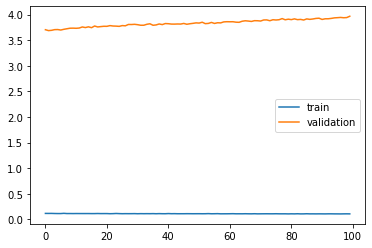

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [22]:
#import tensorflow as tf
#tf.keras.backend.set_learning_phase(0)
#Converter = tf.lite.TFLiteConverter.from_keras_model(model)
#Converter.experimental_new_converter = True
#Tflite_model = Converter.convert()
#open("converted_model3G.tflite", "wb").write(Tflite_model)

In [23]:
#model = tf.keras.models.load_model('model_23_11_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

preds.shape

(876, 8)

In [24]:
import numpy as np
X_in = [3,189,48,280,0,0,0,0]
t = model.predict(np.reshape(X_in,(1,8)))

np.argmax(t, axis=2)

array([[   2,   73,  570, 1249,  783,    0,    0,    0]], dtype=int64)

In [25]:
X_in = [3,0,0,0,0,0,0,0]
t = model.predict(np.reshape(X_in,(1,8)))

np.argmax(t, axis=2)

array([[ 18, 552,   0,   0,   0,   0,   0,   0]], dtype=int64)

In [26]:
testX.reshape((testX.shape[0],testX.shape[1]))


array([[  3, 545, 139, ...,   0,   0,   0],
       [  1,  69,  57, ...,   0,   0,   0],
       [ 32,  22, 138, ..., 126,   0,   0],
       ...,
       [ 24,  95,  20, ...,   0,   0,   0],
       [  8, 471,   0, ...,   0,   0,   0],
       [  1,  68, 819, ...,   0,   0,   0]])

In [27]:
trainX[0] #INPUT

array([ 22,   1, 111,   2, 151, 559,   0,   0])

In [28]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [29]:
#deu_tokenizer
#eng_tokenizer
get_word(64,deu_tokenizer)  #INPUT

'পারি'

In [30]:
get_word(111,eng_tokenizer) #OUTPUT

'ask'

In [31]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], deu_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], deu_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [32]:
pred_df = pd.DataFrame({'actual' : test[:,0],'actual2' : test[:,1], 'predicted' : preds_text})

In [33]:
test[:,1]

array(['টম গেটের বাইরে অপেক্ষা করলো।', 'আমি ওকে দৌড়াতে দেখেছিলাম।',
       'তার যা ইচ্ছে সে বলতে পারে।', 'কোনো ভুল নেই।', 'তিনি ফল খাচ্চেন।',
       'ও এখনো আসেনি।', 'টম চিৎকার করলো।', 'এটা আমার নয়।',
       'এখানে দাঁড়ান।', 'আমরা কফি পছন্দ করি।', 'টম কি বাড়িতে আছে',
       'আমার এটা প্রয়োজন ছিলো।', 'আপনার গাড়ি আছে', 'তোমার উত্তর ভুল।',
       'টমের বাবামাও গায়ক ছিলেন।', 'আমি কোথা থেকে আমার মালপত্রটা পাব',
       'আপনি খুব সাহসী।', 'এখানে সই করুন।', 'সবাই পরিশ্রান্ত।',
       'আমি আর টম একলা ছিলাম।', 'আমি সেটা ব্যবস্থা করে দেবো।',
       'ও ভালো মানুষ।', 'তারা চেঁচালো।', 'আমি ভেতরে আছি।',
       'টম চেঁচাতেই থাকলো।',
       'সে প্যারিস গেছে তার কাকিমার সঙ্গে দেখা করতে।',
       'আমি কি এখানে কাজ করতে পারি',
       'ও কী করে না করে আমি তা কেয়ার করি না।', 'টম এত খুশি কখনো হয় নি।',
       'নিজেকে সংজত করো।', 'চেখে দেখো।',
       'তোমাকে ছাড়া এটা করতেই পারতাম না। ধন্যবাদ।', 'তিনি আসতে পারেন।',
       'আমরা যা করতে চাই তাই করি।', 'ঘরের মধ্যে দিয়ে টম মেরির দিকে চাইল।',
       'তিনি এখনো এসে 

In [34]:
pred_df.sample(100)

,actual,actual2,predicted
688,that is my seat,ওটা আমার সীট।,এটা কি তোমার বোন।
75,tom got angry,টম রেগে গেছিলো।,টম রেগে গেছিলো।
743,tom lives in a small town near boston,টম বস্টনের কাছে একটা ছোট শহরে থাকে।,টম আঠারো অবস্থায় ছিলো তখন জন্য গ্রেফতার
785,that was the best day of my life,সেটা আমার জীবনের সব থেকে ভালো দিন ছিল।,আপনি কখন ফিরবেন সবকিছুই আবহাওয়ার উপর নির্ভর
289,my father can fly an airplane,আমার বাবা প্লেন ওড়াতে পারে।,আমার ছেলে আমার ঘরে কাটতে পারে।
...,...,...,...
335,stop tom,টমকে আটকান।,টমকে থামান।
557,he runs,সে দৌড়ায়।,ইনি দৌড়ান।
356,i was at a movie theater,আমি একটা সিনেমা হলে ছিলাম।,আমি এখনো ফাইলটা নামাইনি। করিনি।
269,im not very good at this,আমি এতে খুব একটা ভালো নই।,আমি এই ব্যাপারে খুব একটা ভালো নই।
